# 02 - Create predictive model for NYC Yellow Cab data set

In this notebook, you will

- Launch a [Coiled Cluster](cloud.coiled.io)
- Load a [Dask dataframe](https://tutorial.dask.org/04_dataframe.html) into your workspace
- partition data into training and testing sets
- perform a linear least square regression with 2 independent variables
- use [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html) to train a machine learning model

You will need

- Coiled
- Dask
- Dask-ML: a machine-learning library for Dask
- NumPy
- Matplotlib


## Launch a cluster

The first step is to spin up a Dask Cluster. In Coiled, this is done by creating a `coiled.Cluster` instance, there are [several keyword arguments](https://docs.coiled.io/user_guide/api.html#coiled.Cluster) you can use to specify the details of your cluster further. Please read the [cluster creation documentation](https://docs.coiled.io/user_guide/cluster_creation.html) to know more.

> __Note__: that you will give a name to this cluster, if you don't specify this keyword argument, clusters will be given a unique randomly generated name.

In [1]:
import coiled

The predictive analysis will use [xgboost](https://xgboost.readthedocs.io/en/latest/tutorials/dask.html), so you can create a Coiled software environment using the following command in iPython or Jupyter. 

```python
# import coiled
coiled.create_software_environment(
   name="xgboost-on-coiled",
   conda={
      "channels": [
        "conda-forge"
      ],
      "dependencies": [
        "coiled",
        "dask-ml",
        "dask>=2.23.0",
        "fastparquet",
        "pandas>=1.1.0",
        "python-snappy",
        "s3fs",
        "scikit-learn",
        "xgboost>=1.3.0"
      ]
    }
)
```

This creates a container with xgboost and a few other dependencies. You can open the cluster with your new software environment with the `coiled.Cluster` command and specify `software = <username>/xgboost-on-coiled`. Now, you can define the client to access the cluster. 

In [2]:
# cluster = coiled.Cluster(name="taxi-predict", n_workers=10)
from dask.distributed import Client
cluster = coiled.Cluster(n_workers=10, software='cooperrc/xgboost-on-coiled')

client = Client(cluster)

Output()

You have reached your quota of Coiled credits


ValueError: Unable to create cluster: You have reached your quota of Coiled credits

Once the cluster is created (you can see the status on your [Coiled dashboard](https://cloud.coiled.io/)), you can connect Dask to the cluster by creating a `distributed.Client` instance.

In [33]:
client

<Client: not connected>

## Create data predictions in the cloud - Linear Regression

Now that you have a cluster running and Dask connected to it, do some computations. This example will run the computations on about 84 million rows. You will create a prediction in 3 steps:

1. create the Dask dataframe and select the independent variables
2. partition the data into testing and training sets
3. perform the linear regression using `mean()` and `compute()` 

### 1. Create the Dask dataframe

Here, you load the data into a Dask dataframe from AWS. 

In [ ]:
import dask.dataframe as dd

taxi_full = dd.read_csv(
    "s3://nyc-tlc/trip data/yellow_tripdata_2019-*.csv",
    dtype={
        "payment_type": "UInt8",
        "VendorID": "UInt8",
        "passenger_count": "UInt8",
        "RatecodeID": "UInt8",
    },
    storage_options={"anon": True},
    blocksize="16 MiB",
).persist()

Now, you can remove the data that you found was unnecessary in the previous notebook, [01_Create descriptive statistics for NYC Yellow Cab data set](./Create descriptive statistics for NYC Yellow Cab data set). Save the variable as `taxi_full_wtips`. 

In [5]:
taxi_full_wtips = taxi_full[(taxi_full['tip_amount'] > 0) & 
                            (taxi_full['fare_amount'] > 0) & 
                            (taxi_full['trip_distance'] > 0)].persist()

57996934

### 2. Partition the data into testing and training sets

Load the `model_selection` library from Dask-ML. You will use this function to split the data into training and testing dataframes. The `X` variable holds all of the data except for `tip_amount`. The `y` variable is the `tip_amount`, your observations for predictions. 

```python
from dask_ml.model_selection import train_test_split

X = taxi_full_wtips.loc[:, taxi_full_wtips.columns != 'tip_amount']
y = taxi_full_wtips['tip_amount']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)
```

> __Note__: Need to get more credits to run analysis with partitioned data

In [6]:
import dask
x1, x2, y = taxi_full_wtips['fare_amount'], taxi_full_wtips['trip_distance'], taxi_full_wtips['tip_amount']

x1, x2, y = dask.persist(x1, x2, y)

### 3. Perform the linear regression using `mean()` and `compute()` 

Linear regression minimizes the sum of squares error between a linear function of  dependent variables, 

$f(x_1,~x_2) = \beta + \alpha_1 x_1 + \alpha_2 x_2$

$\min(\sum|y - f(x_1,~x_2)|^2)$

where
- $\beta = offset$
- $x_1 = fare~amount$
- $x_2 = trip~distance$
- $y_1 = tip~amount$

These equations reduce to a single linear algebra equation as such

$\mathbf{Z}^T\mathbf{Z a} = \mathbf{Z}^T\mathbf{y}$

$\left[\begin{array}
~1 & \sum x_1/N & \sum x_2/N \\
\sum x_1/N & \sum x_1^2/N & \sum x_1x_2/N \\
\sum x_2/N &\sum x_1 x_2/N & ~\sum x_2^2/N \end{array}\right]$ = $
\left[\begin{array}
\sum y/N\\
\sum x_1 y/N\\
\sum x_2 y/N\\
\end{array}\right]$

You can use the `mean().compute()` command to calculate this matrix-vector equation. The result is a $3 \times 3$ array, `ZTZ`, and a vector of length 3, `ZTy`. 




In [7]:
Sx1 = x1.mean().compute()
Sx2 = x2.mean().compute()

In [8]:
Sx1x2 = (x1*x2).mean().compute()
Sx1x1 = (x1**2).mean().compute()
Sx2x2 = (x2**2).mean().compute()

In [9]:
import numpy as np
ZTZ = np.array([[1, Sx1, Sx2], 
                [Sx1, Sx1x1, Sx1x2],
                [Sx2, Sx1x2, Sx2x2]])

In [11]:
Sy = y.mean().compute()
Sx1y = (x1*y).mean().compute()
Sx2y = (x2*y).mean().compute()


Now, you have the calculated each array value. You can solve the linear least square problem and calculate $[\beta,~\alpha_1,~\alpha_2]$. 

In [20]:
ZTy = np.array([Sy, Sx1y, Sx2y])

A = np.linalg.solve(ZTZ, ZTy)
A

array([0.61165532, 0.17636812, 0.07329121])

The result is that the predicted tip from this data set is:

$tip = \$0.60 + 0.18\cdot (\$total~fare) + 0.07\frac{\$}{mi}(trip~distance [mi])$

You can use the subset of data from [0 - Exploring the NYC Yellow taxi data set](./00_explore-taxi.ipynb) to visually inspect the model. 

Import Matplotlib and Pandas. Then, apply the same filter to the data to remove 0's. 

In [30]:
import matplotlib.pyplot as plt
import pandas as pd
taxi_subset = pd.read_csv('./nyc-taxi-coiled/yellow_tripdata_2018-01_0-end-by-1000.csv')
taxi_subset = taxi_subset[(taxi_subset['tip_amount'] > 0) & 
                        (taxi_subset['fare_amount'] > 0) & 
                        (taxi_subset['trip_distance'] > 0)]

Now, you can apply your data to the `taxi_subset` dataframe. You can directly plug in the equation from above as such 

`predicted_tip = A[0]+A[1]*taxi_subset['fare_amount']+A[2]*taxi_subset['trip_distance']`

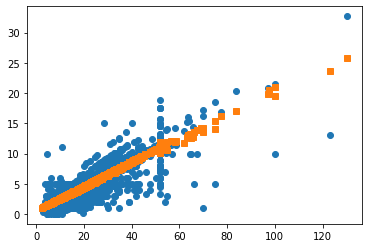

In [32]:
plt.plot(taxi_subset['fare_amount'], taxi_subset['tip_amount'], 'o')
plt.plot(taxi_subset['fare_amount'], 
         A[0]+A[1]*taxi_subset['fare_amount']+A[2]*taxi_subset['trip_distance'], 's')

> __Note__: Need more credits to get the xgboost running here. Had a bunch of debugging that used up the credits. 

In [9]:
# import dask.array as da

# X_array = X.to_dask_array(lengths = True)
# y_array = y.to_dask_array(lengths = True)

In [10]:
# from dask_glm.estimators import LinearRegression

In [14]:
import xgboost as xgb
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train) 

ModuleNotFoundError: No module named 'xgboost'

In [52]:
xgb.__doc__

'XGBoost: eXtreme Gradient Boosting library.\n\nContributors: https://github.com/dmlc/xgboost/blob/master/CONTRIBUTORS.md\n'

In [48]:

import dask

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle = False)
X_train, X_test, y_train, y_test = dask.persist(X_train, X_test, y_train, y_test)

In [56]:
dtrain = xgb.dask.DaskDMatrix(client, X_train, y_train) 
dtrain

In [57]:
output = xgb.dask.train(
    client=client,
    params={
        'objective': 'binary:logistic',
        'max_depth': 8
    },
    dtrain=dtrain,
    num_boost_round=10,
    evals=[(dtrain, 'train')]
)

ModuleNotFoundError: No module named 'xgboost'

In [54]:
output = xgb.dask.train(client,
                        {'verbosity': 2,
                         'tree_method': 'hist',
                         'objective': 'reg:squarederror'
                         },
                        dtrain,
                        num_boost_round=4, evals=[(dtrain, 'train')])

ModuleNotFoundError: No module named 'xgboost'

In [26]:
est = LinearRegression(fit_intercept = False)

In [28]:
est.fit(X_train['fare_amount'], y_train)
est.score(X_train['fare_amount'], y_train)

TypeError: 'numpy.float64' object does not support item assignment

## Wrapping up

In this notebook, you created a prediction for taxi driver tips based upon over 84 million taxi rides in NYC. 

In [58]:

coiled.delete_cluster(name="taxi-predict")
client.close()

Cluster deleted successfully.